### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot variables distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from hist.intervals import ratio_uncertainty
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector

/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
# load the slimmedtree files using uproot
# if run on PKU cluster, use this:
CustNanoData = {
    'TT_Semilep'          : "/data/bond/zhaoyz/Pheno/slimmedtree/v2/merged/slim_delphes.root",
}
files = { }
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"})

In [3]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/distribution/23Jun2024"
_ = os.system(f"mkdir -p {plot_dir}")

In [31]:
#gen-matching results: bkg
files["b_top_matched_bqq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bqq"] == 1) & (files["TT_Semilep"]["isWcb"] == 0 )]
files["b_top_matched_bq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bq"] == 1) & (files["TT_Semilep"]["isWcb"] == 0 )]
files["b_w_matched_others"] = files["TT_Semilep"][((files["TT_Semilep"]["w_matched_cd"] == 1) | (files["TT_Semilep"]["w_matched_cs"] == 1) | (files["TT_Semilep"]["w_matched_us"] == 1) | (files["TT_Semilep"]["w_matched_ud"] == 1) | (files["TT_Semilep"]["w_matched_ub"] == 1)) & (files["TT_Semilep"]["isWcb"] == 0) ]
files["b_w_matched_cb"] = files["TT_Semilep"][(files["TT_Semilep"]["w_matched_cb"] == 1) & (files["TT_Semilep"]["isWcb"] == 0)]
files["b_others"] = files["TT_Semilep"][((files["TT_Semilep"]["unmatched"] ==1) | (files["TT_Semilep"]["b_matched"] ==1) | (files["TT_Semilep"]["q_matched"] ==1)) & (files["TT_Semilep"]["isWcb"] == 0)]

files["s_top_matched_bqq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bqq"]  ==1 ) & ( files["TT_Semilep"]["isWcb"] == 1)]
files["s_top_matched_bq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bq"] == 1) & ( files["TT_Semilep"]["isWcb"] == 1)]
files["s_w_matched_others"] = files["TT_Semilep"][((files["TT_Semilep"]["w_matched_cd"] == 1) | (files["TT_Semilep"]["w_matched_cs"] == 1) | (files["TT_Semilep"]["w_matched_us"] == 1) | (files["TT_Semilep"]["w_matched_ud"] == 1) | (files["TT_Semilep"]["w_matched_ub"] == 1)) & (files["TT_Semilep"]["isWcb"] == 1) ]
files["s_w_matched_cb"] = files["TT_Semilep"][(files["TT_Semilep"]["w_matched_cb"] == 1) & ( files["TT_Semilep"]["isWcb"] ==1 )]
files["s_others"] = files["TT_Semilep"][((files["TT_Semilep"]["unmatched"] ==1) | (files["TT_Semilep"]["b_matched"] ==1) | (files["TT_Semilep"]["q_matched"] ==1)) & (files["TT_Semilep"]["isWcb"] == 1)]
files["TotalSignal"] = files["TT_Semilep"][( files["TT_Semilep"]["isWcb"] ==1 )]



In [32]:
files["TT_Semilep"]

<Array [{PT_j: 247, Eta_j: 1.11, ... NAK4: 8}] type='813994 * {"PT_j": float32, ...'>

In [33]:
files["TotalSignal"]

<Array [{PT_j: 220, ... NAK4: 10}] type='637 * {"PT_j": float32, "Eta_j": float3...'>

In [34]:
files["s_w_matched_cb"]

<Array [{PT_j: 353, ... NAK4: 10}] type='107 * {"PT_j": float32, "Eta_j": float3...'>

In [35]:
files["s_w_matched_others"]

<Array [] type='0 * {"PT_j": float32, "Eta_j": float32, "Phi_j": float32, "Mass_...'>

### output all the variables for which we can make plots

In [36]:
files["TotalSignal"].fields

['PT_j',
 'Eta_j',
 'Phi_j',
 'Mass_j',
 'Mass_j_sd',
 'top_matched_bqq',
 'top_matched_bq',
 'w_matched_cd',
 'w_matched_cs',
 'w_matched_cb',
 'w_matched_ud',
 'w_matched_ub',
 'w_matched_us',
 'b_matched',
 'q_matched',
 'unmatched',
 'isWcb',
 'NAK8',
 'NAK4']

### plot setting, error setting, histogram setting

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### define main plots function

In [38]:
from matplotlib.cm import get_cmap
plt.style.use(hep.style.ROOT)
def makeplots(arrays, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', nbins=20, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/nbins
    ## canvas initializing
    f = plt.figure(figsize=(10, 12.5))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4,  1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    # hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    # ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[1])
    # ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["b_top_matched_bqq","b_top_matched_bq","b_w_matched_others","b_others","b_w_matched_cb"]
    name_dict_sig = [
        #sig
        "TotalSignal"           ,
        "s_top_matched_bqq"     ,
        "s_top_matched_bq"      ,
        "s_w_matched_others"    ,
        "s_w_matched_cb"        ,
        "s_others"           ,

    ]
    for (k,v) in arrays.items():
        if (k not in BKG) and (k not in name_dict_sig) : continue
        hist = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        hist.fill(values, weight = 1.0) #weight to be added in the future
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black'}
    SIG_DECO_COLOR = {'TotalSignal': 'black',"s_w_matched_cb":"blue","s_top_matched_bqq":"pink","s_top_matched_bq":"gray","s_w_matched_others":"green","s_others":"orange"}
    # ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["b_top_matched_bqq","b_top_matched_bq","b_w_matched_others","b_others","b_w_matched_cb"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        # corresponds to Rest, WJets, TT, ST, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        print(bkg_h)
        bkg_err = np.sum(err_list ,  axis=0)
        print(bkg_err)
        bin_edges = np.linspace(x_min, x_max, nbins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Stat. Unc.",
        }
        ax.stairs(values = bkg_h - bkg_err[0], baseline = bkg_h + bkg_err[1], edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    
    
    for (k,h) in individual['h'].items():
        if k == "data": 
            #not used here
            pass
        else:  # signal
            if deco != True: #plot signal in different production mode
                if k in ["TotalSignal"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_COLOR[k])
            
            else: #plot signal in signal decomposition mode
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["TotalSignal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "TotalSignal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            
            if k == "TotalSignal": #print optimal cut information
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                # best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                # print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            if k == "TotalSignal" and optimal_cut == True:
                cut_value_low = x_min + best_lower * (x_max - x_min)/nbins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/nbins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Un-weighted events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    # ax1.set_xlim(x_min, x_max)
    # ax1.set_xticklabels([])
    # if fraction_log:
    #     ax1.set_ylim(1e-1, 1e1)
    #     ax1.set_yscale('log')
    # else:
    #     # ax1.set_ylim(0, 2)
    #     ax1.set_ylim(0.3, 1.8)
    # ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    # ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=16)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}{nametext}.pdf", bbox_inches='tight')
    plt.show()

### define the cut for each regions, for examples, SRs, CRs, PS and MET regions here:

In [39]:
CUT = {        
  
    "PS"  : {k:  (files[k]["PT_j"] >= 0)  for k in files}, 
  
    }

# CR: tagger < 0.9

### define the variables we want to plot

In [40]:
def run_makeplots(region = "PS", events = files, nametext = "", blind = False, othertext = "", deco = False, optimal_cut = True):
    # weight={k: events[k][CUT[region][k]]["weight"] for k in events}  # weight for each event
    makeplots(arrays = {k: events[k][CUT[region][k]]["Mass_j_sd"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='mass', x_name=r'$jet_{1}$:PUPPI jet mass', x_max=200, x_min=0, nbins=20,  year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    makeplots(arrays = {k: events[k][CUT[region][k]]["PT_j"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='pT', x_name=r'$jet_{1}$:PUPPI jet pT', x_max=800, x_min=200, nbins=20,       year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    makeplots(arrays = {k: events[k][CUT[region][k]]["Eta_j"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='eta', x_name=r'$jet_{1}$,$\eta$', x_max=3, x_min=-3, nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    makeplots(arrays = {k: events[k][CUT[region][k]]["Phi_j"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='phi', x_name=r'$jet_{1}$,$\phi$', x_max=-3.2, x_min=3.2, nbins=32, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # add the variables you want to plot here, like above.

### make plots for each region, some examples are shown here

/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value enco

[138574.  67455.  34829.  28020.  30013.  39482.  57656.  83512.  96144.
  73231.  48632.  33551.  23239.  16490.  11548.   9061.   7213.   5603.
   3714.   2161.]
[[483.70890894 351.9834541  270.45360954 260.68182088 284.83614542
  341.73233664 427.27548731 519.24515995 556.63340054 495.0724421
  410.84037959 346.69852667 292.52274219 248.36521091 208.6118811
  180.85152033 153.81245276 129.36503229 103.70737938  80.36397812]
 [483.70890894 351.9834541  270.45360954 260.68182088 284.83614542
  341.73233664 427.27548731 519.24515995 556.63340054 495.0724421
  410.84037959 346.69852667 292.52274219 248.36521091 208.6118811
  180.85152033 153.81245276 129.36503229 103.70737938  80.36397812]]
Should scale signal *  1273.7861615192041
Optimal two-side cut = 0 20 0.706610401782167
Optimal one-side cut = 0 0.7066108335312705


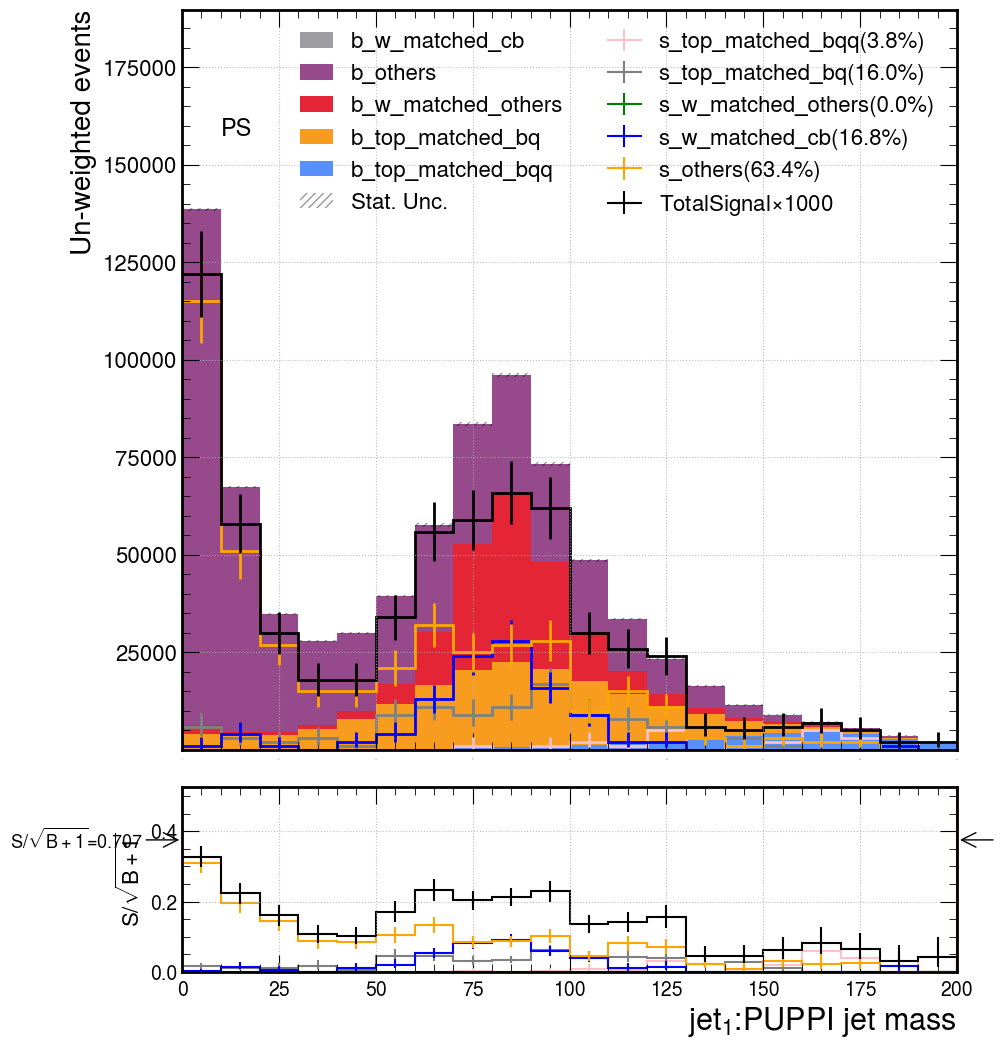

/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value enco

[262706. 174022. 116383.  78970.  53896.  37366.  26314.  18525.  12756.
   9062.   6514.   4429.   3251.   2423.   1701.   1275.    935.    659.
    513.    393.]
[[862.95466498 728.86183016 612.78228244 519.0887567  438.25994566
  372.25200913 315.37901123 265.04266553 219.48026081 184.13811556
  154.80960445 127.02330006 108.12549458  92.15592175  76.63792522
   65.82540754  55.84570518  46.89570622  40.99845553  35.64398221]
 [862.95466498 728.86183016 612.78228244 519.0887567  438.25994566
  372.25200913 315.37901123 265.04266553 219.48026081 184.13811556
  154.80960445 127.02330006 108.12549458  92.15592175  76.63792522
   65.82540754  55.84570518  46.89570622  40.99845553  35.64398221]]
Should scale signal *  1274.8712695841896
Optimal two-side cut = 0 19 0.7070357795540148
Optimal one-side cut = 0 0.7068651103396594


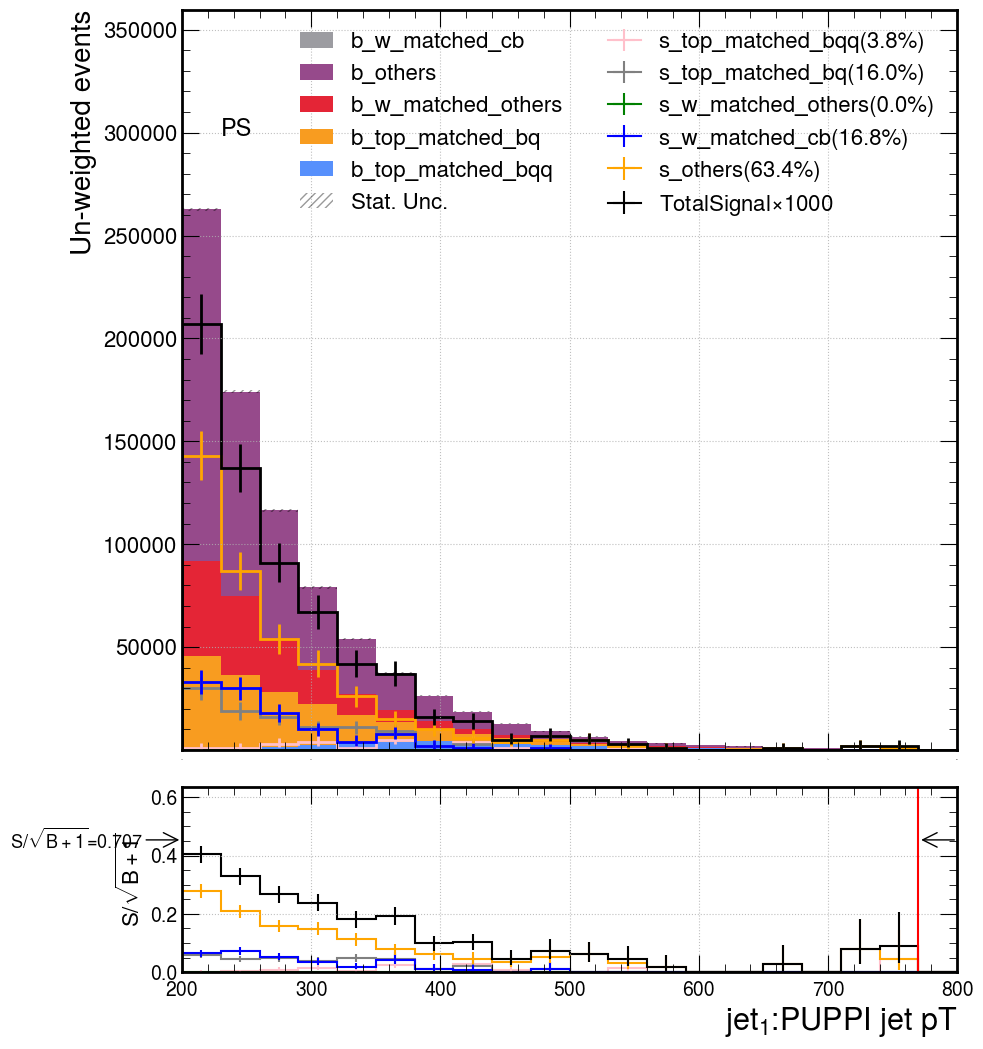

/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value enco

[3.0000e+00 9.3000e+01 3.4010e+03 1.0079e+04 1.4515e+04 1.8551e+04
 2.3316e+04 2.8383e+04 3.3575e+04 3.8118e+04 4.2216e+04 4.5495e+04
 4.8660e+04 5.0179e+04 5.0708e+04 5.0690e+04 4.9920e+04 4.7879e+04
 4.5396e+04 4.2115e+04 3.8351e+04 3.3317e+04 2.8214e+04 2.3702e+04
 1.8748e+04 1.4322e+04 9.9440e+03 3.3710e+03 9.5000e+01 0.0000e+00]
[[  1.63        11.89398113  93.24818532 170.80299708 211.36400147
  241.23966556 275.12857016 306.93231351 336.17562835 361.41151827
  380.78567411 397.46278375 411.65413079 419.06048452 421.39412897
  420.56559989 416.49931891 408.13134693 396.82590922 380.84887391
  362.19223859 334.84524501 305.48209498 277.70655301 242.70762997
  208.57288266 168.81136871  93.12378788  14.64538514   0.        ]
 [  2.92        14.65398113  93.24818532 170.80299708 211.36400147
  241.23966556 275.12857016 306.93231351 336.17562835 361.41151827
  380.78567411 397.46278375 411.65413079 419.06048452 421.39412897
  420.56559989 416.49931891 408.13134693 396.82590922 380.84

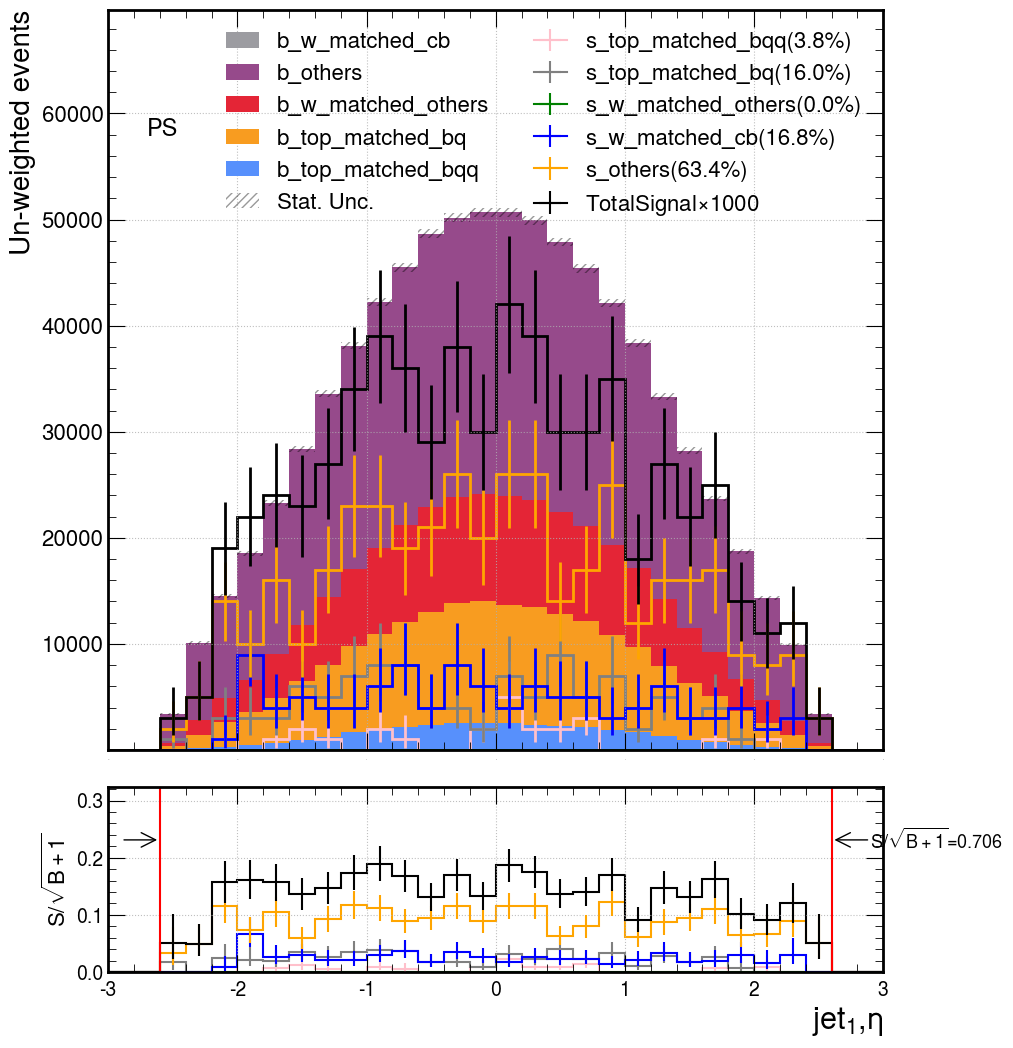

/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2865954/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2865954/314159992.py:52: RuntimeWarning: invalid value enco

[18495. 25645. 25666. 25963. 26228. 25808. 25801. 25883. 25806. 25863.
 25696. 25950. 25922. 25932. 25897. 25748. 25788. 25844. 25707. 26005.
 26404. 25675. 25869. 25613. 26025. 25869. 26033. 26238. 26022. 25913.
 25660. 18389.]
[[250.66665433 294.33953093 295.34184965 296.93422741 298.65791894
  296.43735428 295.92486347 295.96624067 296.25555999 296.67828497
  295.29037959 297.2492935  296.66500646 296.8306514  296.64038818
  296.35372388 295.74021761 296.13605108 295.18511997 297.74305543
  299.72052357 295.62020437 296.544455   294.78192141 297.16915714
  296.12993788 298.04152143 298.96204032 296.62784716 296.94688872
  295.08971726 249.89881603]
 [250.66665433 294.33953093 295.34184965 296.93422741 298.65791894
  296.43735428 295.92486347 295.96624067 296.25555999 296.67828497
  295.29037959 297.2492935  296.66500646 296.8306514  296.64038818
  296.35372388 295.74021761 296.13605108 295.18511997 297.74305543
  299.72052357 295.62020437 296.544455   294.78192141 297.16915714
  296

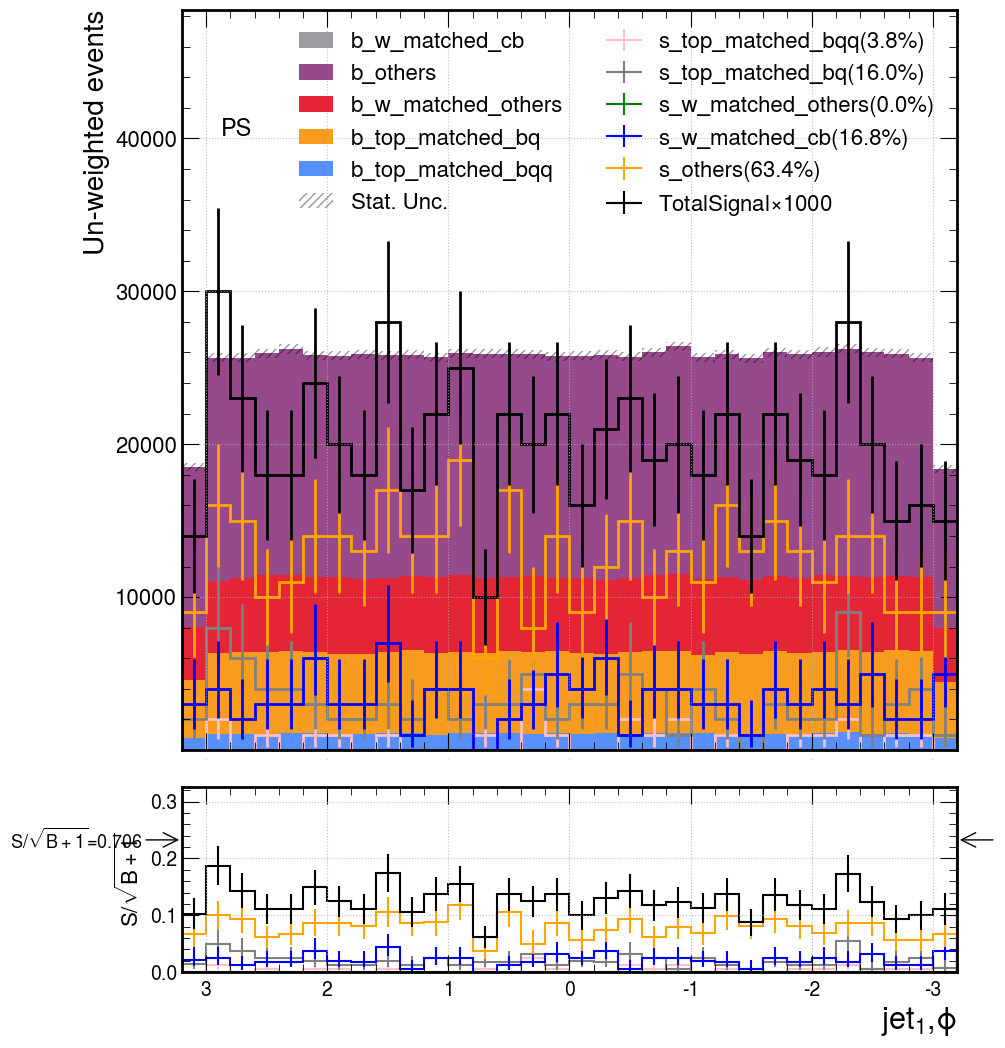

In [41]:
run_makeplots(region = "PS",  blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "SR1", blind = True,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "SR2", blind = True,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "SR3", blind = True,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "CR",  blind = False,  othertext = "", deco = True) #this set to deco to True